# Tensorflow Image Classification 

Followed tutorial by tensorflow found [here](https://www.tensorflow.org/tutorials/images/classification), with modifications adapted for our implementation. 

## Setup
Installing required python packages. Then importing the packages needed. 

In [85]:
# %%capture
# %pip install matplotlib numpy tensorflow tensorflow_datasets

In [86]:
import numpy as np
import math
from datetime import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds  


## Dataset 
Dataset taken from Dataset repository.

In [87]:
dataset = keras.utils.image_dataset_from_directory(
    directory="./own_dataset",
    labels="inferred",
    color_mode="rgb",
    image_size=(1280, 960),
    shuffle=True,
    batch_size=None,
)

dataset_size = 340
dataset_label = dataset.class_names
dataset_label_size = len(dataset_label)
dataset_train_size = int(0.5*dataset_size)
dataset_validate_size = int(0.2*dataset_size)
dataset_test_size = int(0.3*dataset_size)

dataset_train = dataset.take(dataset_train_size)
dataset_validate = dataset.skip(dataset_train_size).take(dataset_validate_size)
dataset_test = dataset.skip(dataset_train_size+dataset_validate_size)

print(f"dataset size: {dataset_size}")
print(f"dataset labels: {dataset_label}")
print(f"number of labels: {dataset_label_size}")
print(f"train dataset size: {dataset_train_size}") 
print(f"validate dataset size: {dataset_validate_size}") 
print(f"test dataset size: {dataset_test_size}")  

Found 340 files belonging to 4 classes.
dataset size: 340
dataset labels: ['nothing', 'paper', 'rock', 'scissor']
number of labels: 4
train dataset size: 170
validate dataset size: 68
test dataset size: 102


## Hyperparameters 
In the following code section, hyperparameters are defined. 
- **image_size**: is the lengths of the image in both height and width (this requires the images to be square).
- **epochs**: is the number of epochs for training. 
- **batch_size**: is the number of samples in each mini batch. Generally a larger _batch_size_ allows for better utilization of GPU, where 32 & 64 are recommended.

In [88]:
time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
filepath = "./saved_models/tensorflow_image_classification/"+time+"/"

image_size = 900
epochs = 100
batch_size = 256

## Dataset Formatting
### Image Formatting
In the following code section each of the images within the datasets are reformated. The image is resized according to the hyperparameters. The resizing is done by map over the dataset where the function which resizes is applied to each index within the dataset. 

In [89]:
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    return image, label


dataset_train = dataset_train.map(format_image)
dataset_validate = dataset_validate.map(format_image)
dataset_test = dataset_test.map(format_image)

### Dataset Buffered Prefetching
This step is important especially for performance but also for how the dataset will function when training. 
- **cache**: Keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- **shuffle**: Will allocate a buffer with random entries, the buffer size will have the size equal to the _buffer_size_. 
- **batch**: Will take _batch_size_ number of elements into separate batches. 
- **repeat**: Normally images are put from the dataset into the buffer and when the dataset is empty it will return an error. Repeat will re-initialize the dataset by making it again so that this error never occurs. 
- **prefetch**: Overlaps data preprocessing and model execution while training.

In [90]:
AUTOTUNE = tf.data.AUTOTUNE

dataset_train = dataset_train.cache().shuffle(1000).batch(batch_size=batch_size).repeat().prefetch(buffer_size=AUTOTUNE)
dataset_validate = dataset_validate.cache().repeat().batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)
dataset_test = dataset_test.cache().repeat().batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)

## Models
### Augmentation Model
In the following step we create a augmentation model, to avoid overfitting and allow our network to function better against new images.

In [91]:
augmentation_model = tf.keras.Sequential(
    layers=[
        tf.keras.layers.RandomFlip(
            mode="horizontal",
            input_shape=(image_size, image_size, 3),
        ),
        tf.keras.layers.RandomRotation(factor=0.1),
        tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.GaussianNoise(stddev=0.1)
    ], 
    name="augmentation_model")


### Network Model
In the following code cell we define the network model.

In [92]:
model = tf.keras.Sequential(
    layers=[
        tf.keras.layers.Rescaling(
            scale=1./255, input_shape=(image_size, image_size, 3)),
        augmentation_model,
        tf.keras.layers.Conv2D(
            filters=16, 
            kernel_size=3, 
            input_shape=(image_size, image_size, 3), 
            padding='same', 
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(
            filters=32, 
            kernel_size=3, 
            input_shape=(image_size, image_size, 3), 
            padding='same', 
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(
            filters=64, 
            kernel_size=3, 
            input_shape=(image_size, image_size, 3), 
            padding='same', 
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(dataset_label_size, name="outputs")], 
    name="classification_model")

### Model Compilation
Configures the model for training. 
- **optimizer**: The name of the optimizing method used. 
- **loss**: Loss function used. 
- **metrics**: List of metrics used to evaluate the model during training. 

In [93]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
model.summary()

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 augmentation_model (Sequent  (None, 128, 128, 3)      0         
 ial)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 16)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 32

## Training Of Model
In the following section the dataset is trained. 
- **x**: The training dataset. 
- **epochs**: Number of epochs in the training. 
- **verbose**: Setting for console output. 
- **validation_data**: The validation dataset. 
- **steps_per_epoch**: Number of elements handled in each step during a single epoch.
- **validation_steps**: Same as _steps_per_epoch_ but for the validation of a epoch.  

In [94]:
training_result = model.fit(
    x=dataset_train,
    epochs=epochs,
    verbose=1,
    validation_data=dataset_validate,
    steps_per_epoch=math.ceil(dataset_train_size / batch_size),
    validation_steps=math.ceil(dataset_validate_size / batch_size),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy')],
)

Epoch 1/100
1/1 [==============================] - 11s 11s/step - loss: 1.4364 - accuracy: 0.2588 - val_loss: 2.4272 - val_accuracy: 0.2266
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 3.6567 - accuracy: 0.2529 - val_loss: 2.6578 - val_accuracy: 0.2695
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 4.7153 - accuracy: 0.3118 - val_loss: 1.9000 - val_accuracy: 0.1914
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 3.0542 - accuracy: 0.2059 - val_loss: 1.4861 - val_accuracy: 0.1914
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 1.7961 - accuracy: 0.2059 - val_loss: 1.3904 - val_accuracy: 0.2227
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 1.4042 - accuracy: 0.2294 - val_loss: 1.3808 - val_accuracy: 0.3125
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 1.3947 - accuracy: 0.2294 - val_loss: 1.3807 - val_accuracy: 0.3125
Epoch 8/100
1/1 [===============

## Evaluation Of Model
In the following code section the model is evaluated by running the test dataset through the trained model. 

In [95]:
testing_result = model.evaluate(
    x=dataset_test,
    verbose=1,
    steps=math.ceil(dataset_test_size / batch_size),
)

1/1 [==============================] - 3s 3s/step - loss: 1.3866 - accuracy: 0.2266


## Save Model

In [96]:
acc = training_result.history['accuracy']
val_acc = training_result.history['val_accuracy']
test_acc = testing_result[1]

loss = training_result.history['loss']
val_loss = training_result.history['val_loss']
test_loss = testing_result[0]

https://www.tensorflow.org/tutorials/keras/save_and_load

In [97]:
model.save_weights(filepath+"model")

f = open(filepath+"result", "w")
f.write(f"train accuracy: {acc[-1]} \ntrain loss: {loss[-1]} \nvalidate accuracy: {val_acc[-1]} \nvalidate loss: {val_loss[-1]} \ntest accuracy: {test_acc} \ntest loss: {test_loss}")
f.close()

## Visualization of Result
Visualization in graphs of the training, validation and testing results. 

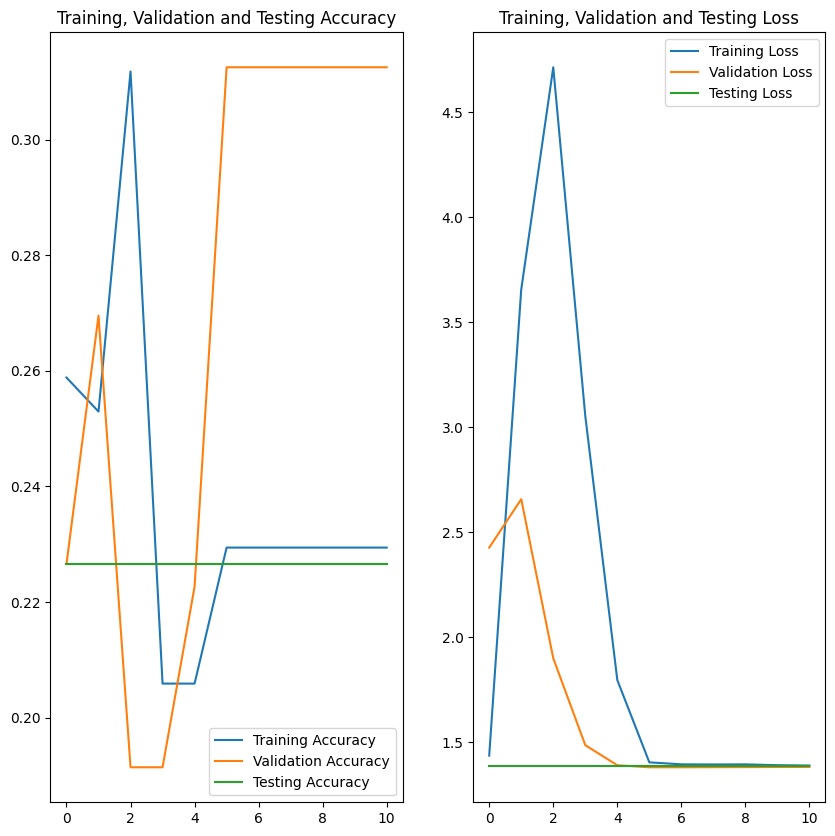

In [98]:
epochs_range = range(len(acc))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, [test_acc]*len(epochs_range), label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training, Validation and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.plot(epochs_range, [test_loss]*len(epochs_range), label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training, Validation and Testing Loss')
plt.savefig(filepath+"result.png")
plt.show()
